In [100]:
import numpy as np
import torch
from pytorch3d.transforms import quaternion_apply, axis_angle_to_quaternion

from torch.utils.data import Dataset

import pandas as pd


class JointDataset(Dataset):
    def __init__(self, x, joint_names):
        super().__init__()
        self.joint_names = joint_names
        self.furthest_distance = None
        self.centroid = None
        self.reference_idx = None
        self.x = self._transform(self._scale(x))

    def __len__(self):
        return self.x.size(0)

    def __getitem__(self, idx):
        return self.x[idx]

    def _scale(self, x):
        # Center the points and reduce to unit-sphere
        x = x.reshape(-1, 3)
        self.centroid = torch.mean(x, axis=0)
        x -= self.centroid
        self.furthest_distance = torch.max(torch.sqrt(torch.sum(x ** 2, axis=-1)))
        x /= self.furthest_distance
        # Put back into the original shape
        x = x.reshape(-1, 32, 3)
        return x

    def _unscale(self, x):
        if self.furthest_distance is None:
            raise ValueError("Dataset has not been scaled yet")
        x *= self.furthest_distance
        x += self.centroid
        return x

    def _transform(self, x):
        """
            Compute the transformation matrix that transforms the reference points into the target points.
            references = torch.from_numpy(np.random.randint(0, 10, size=((n_obs, 3)))).float()
            targets = torch.from_numpy(np.random.randint(0, 10, size=((n_obs, n_joints, 3)))).float()
        """

        # We use the pelvis as the reference
        pelvis_idx = list(self.joint_names).index("PELVIS")
        self.reference_idx = pelvis_idx

        # Get the references
        references = x[:, self.reference_idx]

        # Split the tensor into two parts, before and after the pelvis_idx
        first_part = x[:, :self.reference_idx]
        second_part = x[:, self.reference_idx+1:]

        # Stack the two parts together
        targets = torch.cat((first_part, second_part), dim=1)

        # Get the number of joints
        n_joints = targets.size(1)

        # Normalize references and targets
        normalized_ref = references / torch.norm(references, dim=-1, keepdim=True)
        normalized_tgt = targets / torch.norm(targets, dim=-1, keepdim=True)

        # Calculate the axis of rotation
        axis = torch.cross(normalized_ref.unsqueeze(1), normalized_tgt)
        axis = axis / torch.norm(axis, dim=-1, keepdim=True)

        # The angle of rotation is the arccosine of the dot product of the normalized vectors
        angle_of_rotation = torch.acos((normalized_ref.unsqueeze(1) * normalized_tgt).sum(-1))

        # The axis-angle representation is the axis of rotation scaled by the angle of rotation
        axis_angle = axis * angle_of_rotation.unsqueeze(-1)

        # Convert the axis-angle representation to a quaternion
        rotation = axis_angle_to_quaternion(axis_angle)

        # Apply the rotation to references
        rotated_ref = quaternion_apply(rotation, references.unsqueeze(1).expand(-1, n_joints, -1))

        # Compute the translation vector
        translation = targets - rotated_ref

        transformations = torch.cat((rotation, translation), dim=-1)
        flatten_transformations = transformations.reshape(transformations.size(0), -1)

        data = torch.cat((references, flatten_transformations), dim=-1)

        return data

    def _untransform(self, x):

        n_joints = len(self.joint_names)

        references = x[:, :3]
        references = references.unsqueeze(1)

        transformation = x[:, 3:]
        transformation = transformation.reshape(-1, n_joints-1, 7)

        rotation = transformation[:, :, :4]
        translation = transformation[:, :, 4:]

        # Apply the rotation
        rotated = quaternion_apply(rotation, references.expand(-1, n_joints-1, -1))

        # Apply the translation
        transformed = rotated + translation

        # Put back things together
        data = torch.cat((transformed[:, :self.reference_idx, :],
                          references,
                          transformed[:, self.reference_idx:, :]), dim=1)

        return data

    def untransform_and_unscale(self, x=None):
        if x is None:
            x = self.x.clone()
        x = self._untransform(x)
        x = self._unscale(x)
        return x


# Load the data
device=torch.device("cpu")

with open("data/unlabelled/camera/joints/front_sit_stand.csv") as f:
    data = pd.read_csv(f, header=0)
    data = data.rename(columns={"x-axis": "x", "y-axis": "y", "z-axis": "z", "joint_names": "joint_name"})
    # print(data.head())

# Get the unique joint names and frame IDs
joint_names = np.sort(data["joint_name"].unique())
frame_ids = data["frame_id"].unique()

# Create a multi-index using 'frame_id' and 'joint_names'
data.set_index(['frame_id', 'joint_name'], inplace=True)

# Sort the index to ensure the data is in the correct order
data.sort_index(inplace=True)

# Convert the DataFrame to a NumPy array and reshape it
x = data[['x', 'y', 'z']].values.reshape((frame_ids.size, joint_names.size, 3))

# Convert the NumPy array to a PyTorch tensor
x = torch.from_numpy(x).float().to(device)

print("initial x", x[0, -2:])

dataset = JointDataset(joint_names=joint_names, x=x.clone())

initial x tensor([[ 114.7774,   99.2568, 2006.6128],
        [ -86.5698,  105.2187, 2028.3992]])


# Test the transformation

In [99]:
from plot.plot import plot_skeleton_3d

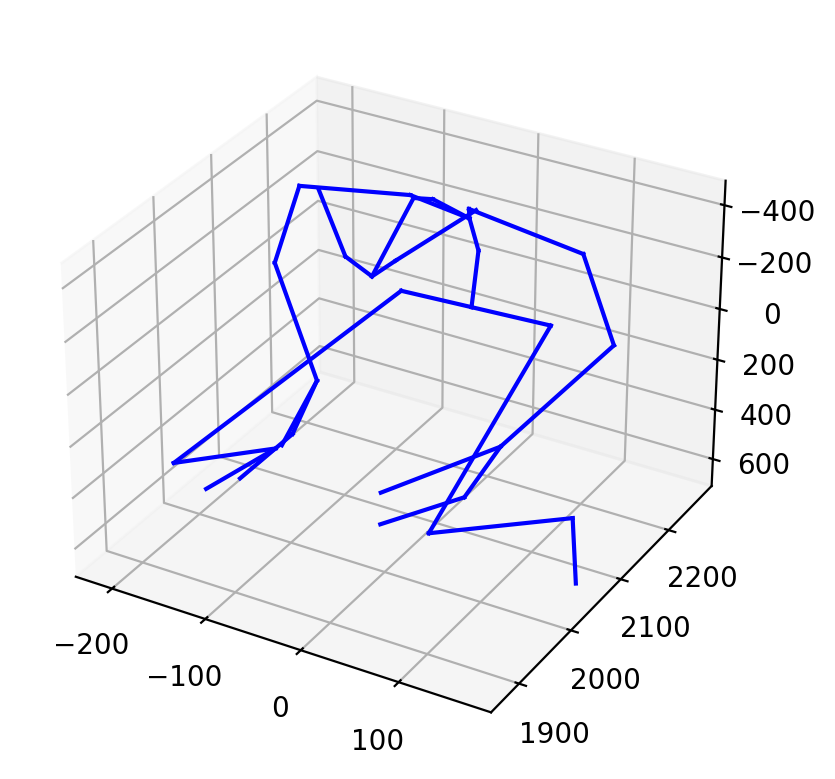

In [101]:
plot_skeleton_3d(x[0], joint_names=dataset.joint_names)

In [102]:
x = dataset.untransform_and_unscale()
print("reconstructed x", x[0, -2:])

reconstructed x tensor([[ 114.7774,   99.2568, 2006.6128],
        [ -86.5698,  105.2187, 2028.3992]])


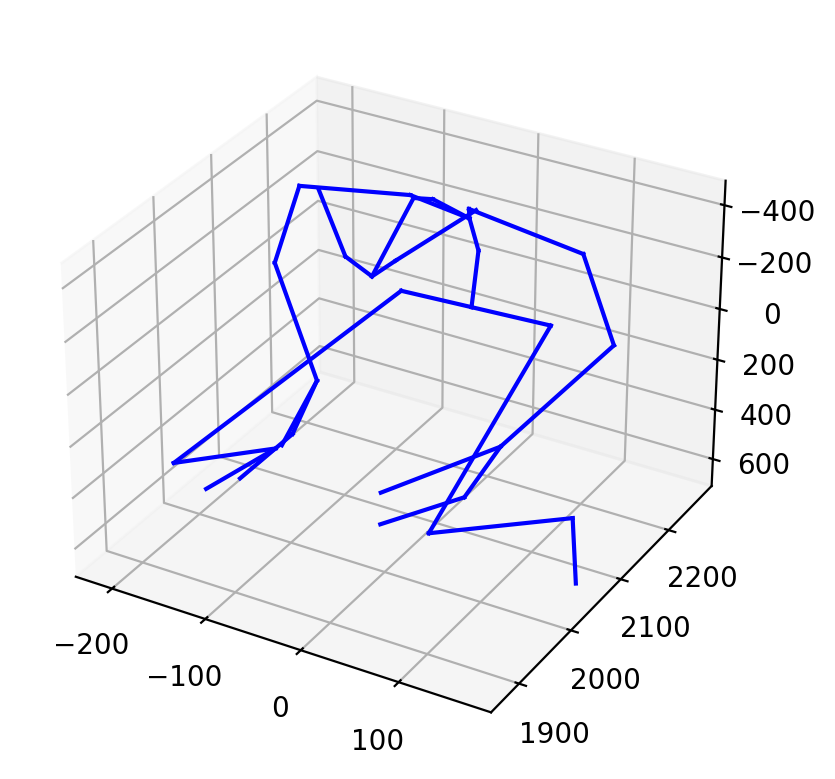

In [103]:
plot_skeleton_3d(x[0], joint_names=dataset.joint_names)